In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import sampen
import sknn

original_dir = os.getcwd()

In [3]:
PLOT=True

In [4]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [5]:
import pywt
# import pyhht

In [6]:
from imp import reload
import auxfilter
import glob

In [7]:
os.chdir(original_dir + '/..')
# os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics

/home/mike/venvs/ml/ml/py


In [8]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>

In [9]:
matplotlib.style.use('ggplot')

In [10]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

Data loading section

In [11]:
dat = dataio.get_matlab_eeg_data_ary('/home/mike/Downloads/train_1/1_100_0.mat')

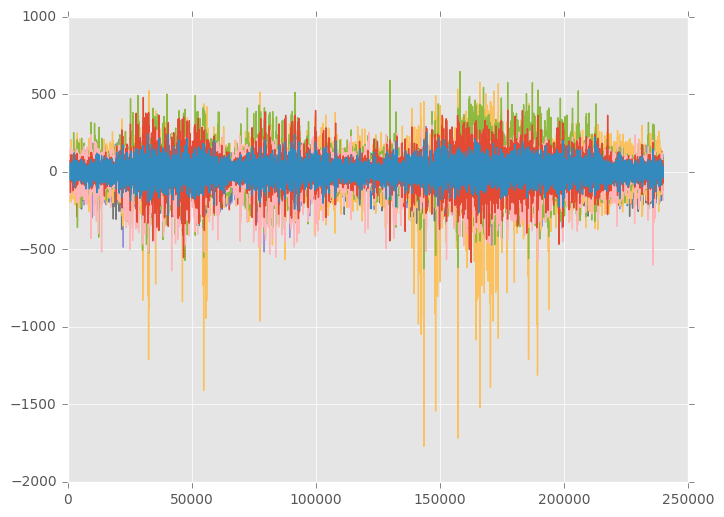

In [12]:
plt.plot(dat)

In [17]:
# dnorm = sampen.sampen2(dat[:,0]) SLOW AF!!!

In [97]:
ls

1_1062_0_44100.wav        pics/
1_1066_0_44100.wav        SampEn/
1_308_0_44100.wav         vec_1478757083.88.npy
1_396_0_44100.wav         vec_1478758610.36.npy
1_404_0_44100.wav         vec_1478816228.31_name.csv
1_558_0_44100.wav         vec_1478816228.31.npy
1_735_0_44100.wav         vec_1478825795.45_name.csv
1_805_0_44100.wav         vec_1478825795.45.npy
3_1000_0_44100.wav        vec_1478970199.15_name.csv
checkpoint                vec_1478970199.15.npy
d0.png                    vec_sampen_1478970808_name.csv
d1.png                    vec_sampen_1478970808.npy
eegkaggle/                vec_sampen_1478971070_name.csv
good_pics/                vec_sampen_1478971070.npy
guess11_10_mlp_256.csv    vec_sampen_1478971675_name.csv
guess11_10_mlp2.csv       vec_sampen_1478971675.npy
guess11_10_mlp3.csv       vec_sampen_1479008817_name.csv
guess11_10_mlp.csv        vec_sampen_1479008817.npy
guess11_10_mlp_pca16.csv  vec_sampen_1479008870_name.csv
guess11_10_perc.csv       vec_sampen_14790

In [12]:
def reload_with_labels(basename):
    data = np.load(basename +'.npy')
    names = pd.read_csv(basename +'_name.csv')
    label = [os.path.basename(name)[:4]+'_'+name[-5] for name in names['path']]
    label2 = []
    for lab in label:
        if lab[:3] == 'new':
            label2.append(-1)
        else:
            label2.append(int(lab[-1]))
    label2 = np.array(label2).reshape(-1,1)
    data = np.nan_to_num(np.array(data, float))
    datav = data.reshape(data.shape[0],-1)
    assert datav.shape[0] == label2.shape[0], "Shape mismatch with data and label"
    return (datav, label2)
    



In [13]:
dd, ll = reload_with_labels('vec_sampen_1479009141')
dd.shape, ll.shape

((3084, 112), (3084, 1))

In [14]:
# data = np.load('vec_sampen_1479009141.npy')
data = np.load('vec_sampen_9078_118.npy')
# names = pd.read_csv('vec_sampen_1479009141_name.csv')
names = pd.read_csv('vec_sampen_9078_118_name.csv')

In [15]:
print(data.shape, names.shape)

(6041, 16, 7) (6041, 2)


In [16]:
label = [os.path.basename(name)[:4]+'_'+name[-5] for name in names['path']]

In [17]:
label2 = []
for lab in label:
    if lab[:3] == 'new':
        label2.append(-1)
    else:
        label2.append(int(lab[-1]))

In [18]:
len(label2)

6041

In [19]:
data = np.nan_to_num(np.array(data, float))
data[data > 100] = 0

In [20]:
datav = data.reshape(-1,16*7)
dataa = np.average(data, axis=1)
dataa = pd.DataFrame(dataa, columns=[range(7)])

In [21]:
dataa.shape

(6041, 7)

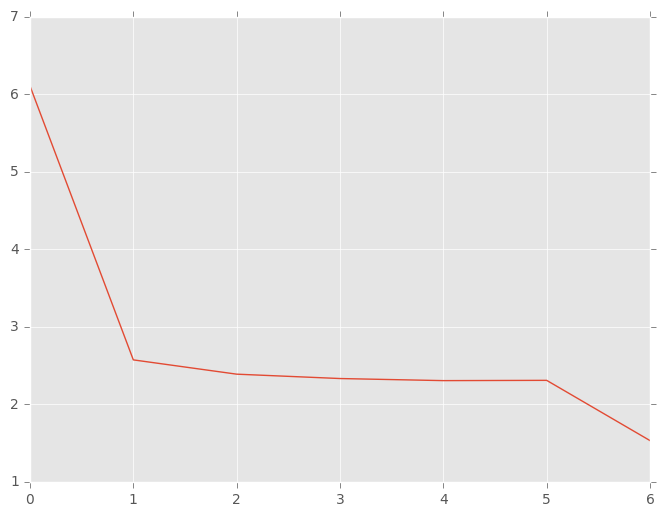

In [22]:
plt.plot(dataa.iloc[1])

In [23]:
dataa['label'] = pd.Series(label2)

In [24]:
d0 = dataa[dataa['label'] == 0]
d1 = dataa[dataa['label'] == 1]

In [25]:
ent0 = dataa[dataa['label'] == 0].mean() / dataa.std()
ent0
ent1 = dataa[dataa['label'] == 1].mean() / dataa.std()


In [26]:
mask = [dataa['label'] == 0, dataa['label'] == 1]
print(mask[0].shape)

(6041,)


In [27]:
ent0z = np.mean(dataa[mask[0]] - dataa[mask[0]], axis=0) #/ np.std(dataa, axis=0)
ent1z = np.mean(dataa[mask[1]] - dataa[mask[1]], axis=0) / dataa.std()

In [28]:
ent0z

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
label    0.0
dtype: float64

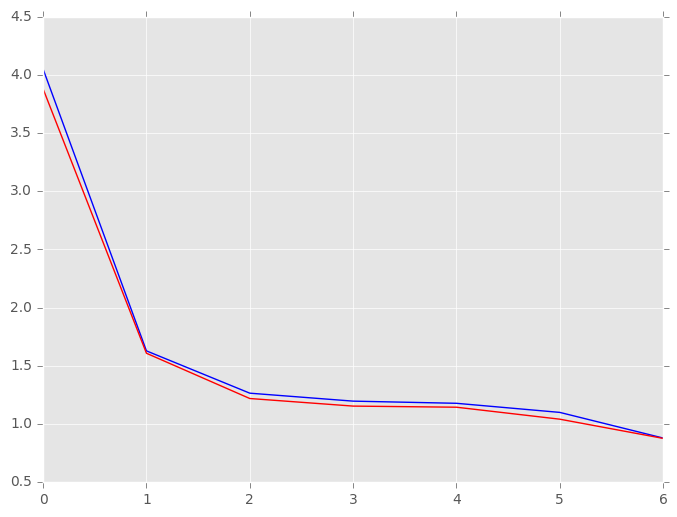

In [29]:
plt.plot(ent0.as_matrix()[:7], 'b')
plt.plot(ent1.as_matrix()[:7], 'r')

In [76]:
ent0m = ent0.as_matrix()
ent1m = ent1.as_matrix()

In [77]:
ent0m.shape

(8,)

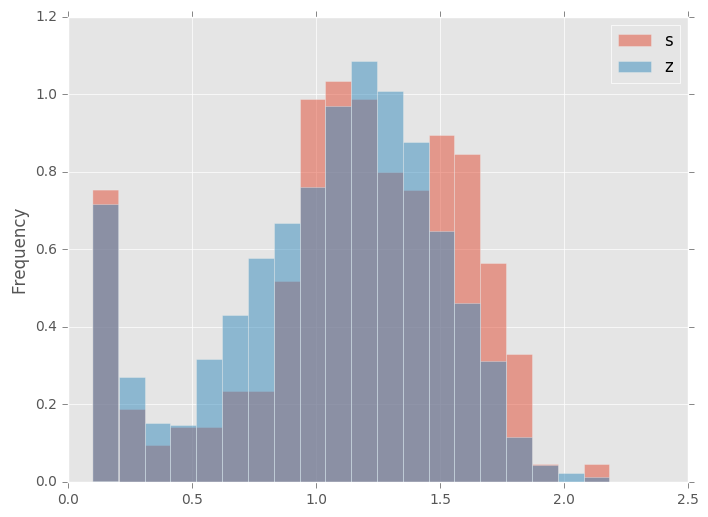

In [80]:
c = 6
df = pd.DataFrame({'s': d1[c][d1[c] > 0.1], 'z': d0[c][d0[c] > 0.1]})
df.plot.hist(alpha=0.5, normed=1, bins=20)

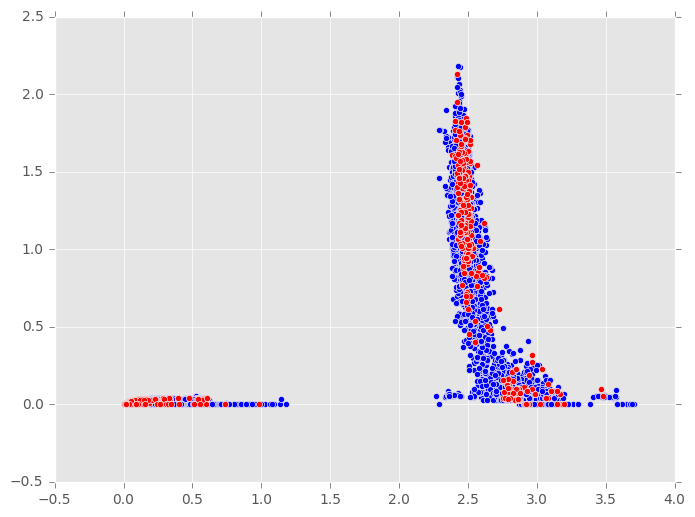

In [85]:
a, b = 2, 6
plt.scatter(d0[a], d0[b] )
plt.scatter(d1[a], d1[b], c='r')

In [30]:
smdata, smlabel = reload_with_labels('vec_sampen_9078_118')
# d0, d1, dt = dataio.separate_sets(smdata, smlabel)


In [31]:
svd = np.load('vec_simple_1479061718.npy')
svd.shape

(6041, 4)

In [32]:
svdata, svlabel = reload_with_labels('vec_simple_1479061718')
sd0, sd1, sdt = dataio.separate_sets(svdata, svlabel)
print(sd0.shape, sd1.shape, sdt.shape)
print(d0.shape)

(5592, 4) (449, 4) (0, 4)
(5592, 8)


In [33]:
d0.dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

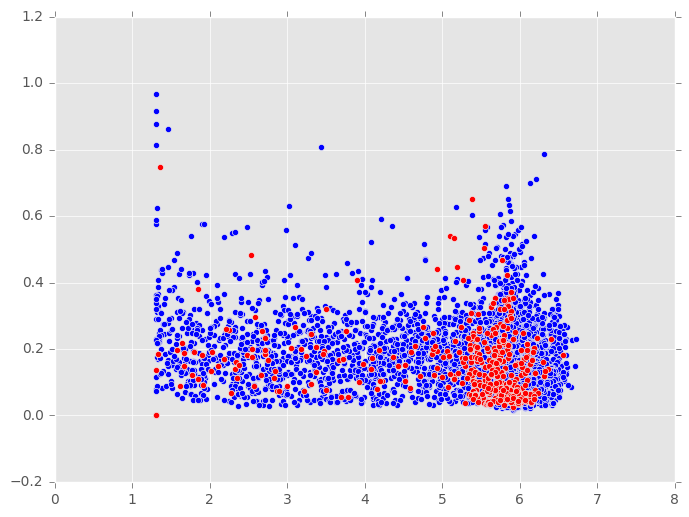

In [34]:
x, y = 0,2
plt.scatter(d0[x], sd0[:,y])
plt.scatter(d1[x], sd1[:,y], c='r')

In [35]:
from sklearn.manifold import TSNE
from sklearn import linear_model as lm, neural_network as nn

In [36]:
d0 = d0.as_matrix()[:,:7]
d1 = d1.as_matrix()[:,:7]

d0.shape


(5592, 7)

In [123]:
# plt.plot(np.mean(d0, axis=0))

In [125]:
def merge_vecs(a_data0, a_data1, b_data0, b_data1):
    vec2data0 = np.concatenate([a_data0.as_matrix(), b_data0], axis=1)
    vec2data1 = np.concatenate([a_data1.as_matrix(), b_data1], axis=1)
    vec2data = np.concatenate([vec2data0, vec2data1], axis=0)
    vec2labels = np.concatenate([np.zeros(len(d0)), np.ones(len(d1))], axis=0)

In [37]:
vec2data0 = np.concatenate([d0, sd0], axis=1)
vec2data1 = np.concatenate([d1, sd1], axis=1)
print(vec2data0.shape, vec2data1.shape)
vec2data = np.concatenate([vec2data0, vec2data1], axis=0)
vec2labels = np.concatenate([np.zeros(len(d0)), np.ones(len(d1))], axis=0)

vec2data.shape, vec2labels.shape

(5592, 11) (449, 11)


((6041, 11), (6041,))

In [38]:
np.save('sampen_simple', vec2data)
np.save('sampen_simple_labels', vec2labels)

In [134]:
d1[:,1:][:,6]

IndexError: index 6 is out of bounds for axis 1 with size 6

In [100]:
model = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
txdata = model.fit_transform(vec2data) 

In [316]:
# model1 = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
# txdata1 = model.fit_transform(vec2data1) 

In [101]:
txdata.shape

(6041, 3)

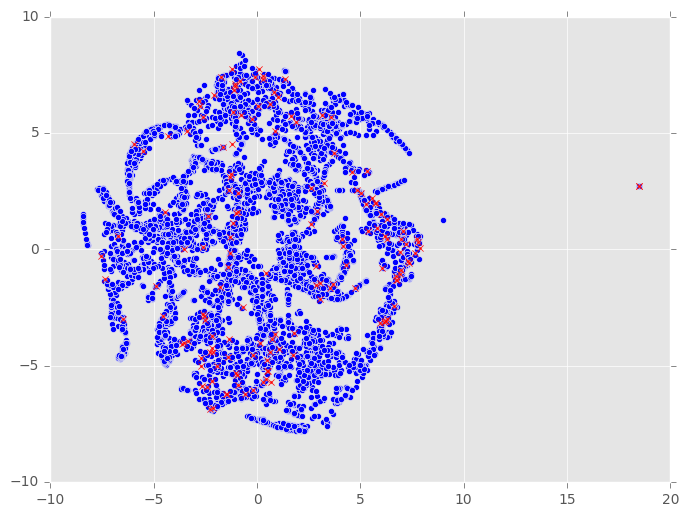

In [102]:
plt.scatter(txdata[:-150,0], txdata[:-150,1])
plt.scatter(txdata[-150:,0], txdata[-150:,1], c='r', marker='.')
plt.scatter(txdata[-150:,0], txdata[-150:,1], c='r', marker='x')

# plt.scatter(txdata1[:,0], txdata1[:,1], c='r')


In [103]:
def subdiv_and_shuffle(data, labels, resample='down', noise=None):
    d0, d1, dt = dataio.separate_sets(data, labels)
    if resample == 'down':
        np.random.shuffle(d0)
        d0 = d0[:len(d1)]
    elif resample == 'up':
        ratio = len(d0)/len(d1)
        mult = int(ratio)+1
        d1 = np.concatenate([d1,]*mult, axis=0)
        
    new_set = np.concatenate([d0, d1], axis=0)
#     print('new set: ', new_set.shape)
    new_labels = np.concatenate([np.zeros(len(d0)), np.ones(len(d1))], axis=0).reshape(-1,1)
#     print('new labels: ', new_labels.shape)
    connected_set = np.concatenate([new_set, new_labels], axis=1)
    np.random.shuffle(connected_set)
    X, Y = np.array(connected_set[:,:-1]), np.array(connected_set[:,-1:])
    return X, Y


In [104]:
X, Y = subdiv_and_shuffle(vec2data, vec2labels)

In [114]:
x1, y1 = subdiv_and_shuffle(txdata, vec2labels, resample='up')
# x1, y1 = txdata, vec2labels
x1 /= 5
y1 = np.array(y1, int)
print(x1.shape, y1.shape)

(11429, 3) (11429, 1)


In [115]:
np.sum(Y)

449.0

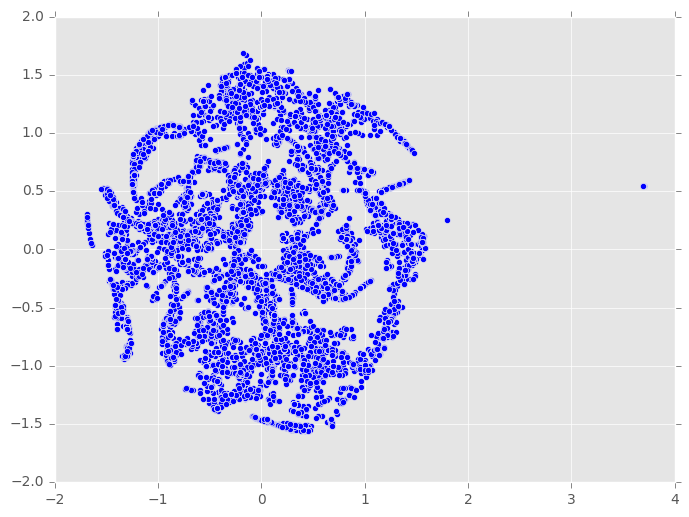

In [116]:
plt.scatter(x1[:,0], x1[:,1])

In [117]:
# mlp = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)


In [118]:
part = len(x1)//2
mlp = nn.MLPClassifier(hidden_layer_sizes=(120,12,120,12,120,12,12), activation='tanh', warm_start=0)
mlp.fit(x1[:part], y1[:part])
# mlp.score(Xv, Yv)
print(mlp.score(x1[part:], y1[part:]))
print(x1[:part].shape, y1[:part].shape, x1[part:].shape, y1[part:].shape)


0.631146106737
(5714, 3) (5714, 1) (5715, 3) (5715, 1)


In [95]:
print(mlp.score(X[part:], Y[part:]))

ValueError: shapes (678,11) and (2,24) not aligned: 11 (dim 1) != 2 (dim 0)

In [96]:
print(np.mean(mlp.predict(X[part:]).reshape(-1,1) == Y[part:]))

ValueError: shapes (678,11) and (2,24) not aligned: 11 (dim 1) != 2 (dim 0)

In [159]:
from sknn import ae
my_ae = ae.AutoEncoder([120,12,120])

AssertionError: Specify each layer as an instance of a `sknn.mlp.Layer` object.